# Notebook de test des données lapi post-traitees

In [494]:
%load_ext autoreload
%autoreload 
import sys #c'est pas propre mais pour le moment pour importer mes modules perso dans le notebook je ne sais pas faire
sys.path.append(r'C:\Users\martin.schoreisz\git\Outils\Outils\Martin_Perso')
import Connexion_Transfert as ct
import donnees_posttraitees as t
import graphs as g
import pandas as pd
import geopandas as gpd
import numpy as np
import altair as alt
import datetime as dt
#pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_columns', 500)
#pd.set_option('display.max_rows', 50)
alt.data_transformers.enable('default', max_rows=None)
import os, math, re
from sklearn.cluster import DBSCAN
from sklearn import svm,datasets
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. import des données, traitement de mise en forme
## 1.1 Import
Les données sont importées sur la période du 24/01/19 au 23/02/19, sur laquelle il n'y a pas de manque de données à priori

In [2]:
%time df_passages_source, df_plaques, df_immat=t.ouvrir_fichier_lapi_final('2019-01-23 00:00:00','2019-02-13 23:59:59')

Wall time: 28min 39s


In [ ]:
#export au format svg des données TV
for i in range(1,20) :
    chemin=os.path.join(r'Q:\DAIT\TI\DREAL33\2018\C17SI0073_LAPI\Traitements\python\graphs\nb_veh_J_cam',f'cam{i}.svg')
    g.graph_nb_veh_jour_camera_multi_j(df_passages,'2019-01-23 00:00:00','2019-01-23 23:59:59',i,22).save(chemin)

## 1.3 Ajout de l'attribut de différenciation VL / PL

In [3]:
%time df_passages2=t.affecter_type(df_passages_source,df_immat)

Wall time: 3min 48s


In [4]:
%time df_passages3=t.affecter_type_nuit(df_passages2,df_immat)

Wall time: 35.6 s


### différenciation VL / PL

In [5]:
df_passages_pl=df_passages3.loc[df_passages3['l']==1].copy()
df_passages_vl=df_passages3.loc[df_passages3['l']==0].copy()

## 1.2. Suppression des doublons

### 1.2.1 Doublons

In [6]:
%%time 
df_passages_pl_ss_doublons=t.supprimer_doublons(df_passages_pl)
df_passages_vl_ss_doublons=t.supprimer_doublons(df_passages_vl)

Wall time: 38.2 s


### 1.2.2 passages proches

In [ ]:
#pour visu
%time groupe_pl_rappro, groupe_pl=t.passages_proches(df_passages_pl_ss_doublons)
jointure = g.analyse_passage_proches(groupe_pl_rappro, groupe_pl)
g.graph_passages_proches(jointure, groupe_pl_rappro)

In [7]:
%%time 
#pour traitement
passg_pl_recale_cam10=t.recalage_cam10(df_passages_pl_ss_doublons)
passg_vl_recale_cam10=t.recalage_cam10(df_passages_vl_ss_doublons)

Wall time: 5min 28s
Parser   : 101 ms


## 1.4. Filtre des immatriculations non cohérentes

In [8]:
%%time 
df_passages_immat_ok, df_immat_suppr=t.filtre_plaque_non_valable(passg_pl_recale_cam10, df_plaques)
df_passages_immat_vl_ok, df_immat_suppr=t.filtre_plaque_non_valable(passg_vl_recale_cam10, df_plaques)

Wall time: 19min 37s


## 1.5 Comparaison lapi - gestionnaire
> Utile pour comparer avec les données gestionnaire, voir avec Gille si donnes de gestionnaires mises en forme

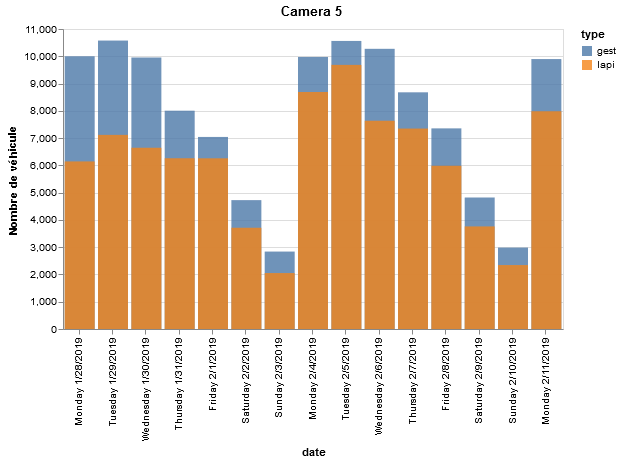

In [333]:
#comparaison des données sur une camera
g.comp_lapi_gest(df_passages_immat_ok,t.donnees_gest,5)

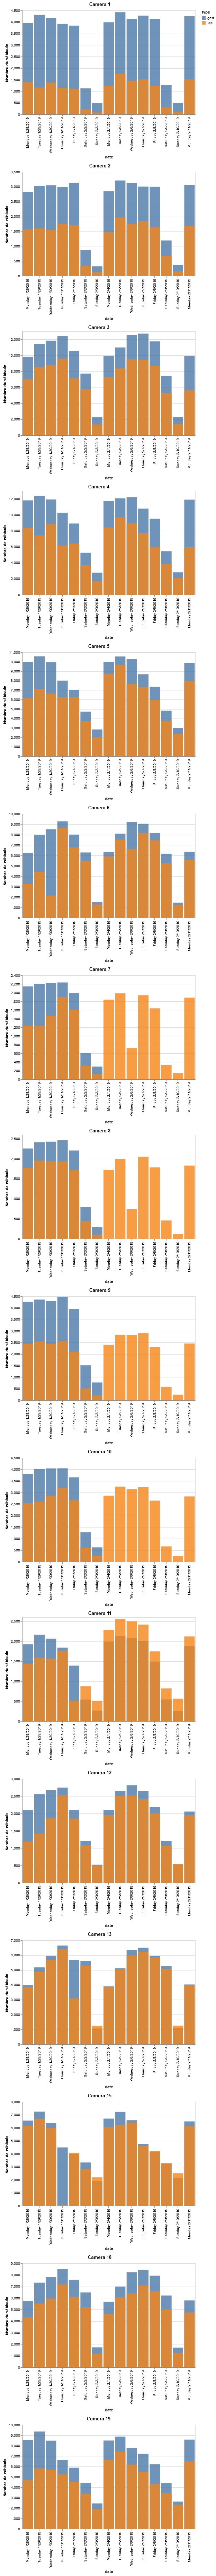

In [330]:
#comparaison des données sur plsuieurs camera
g.comp_lapi_gest_multicam(df_passages_immat_ok,t.donnees_gest)

In [362]:
nb_pl_j_cam=df_passages_immat_ok.groupby('camera_id').resample('D').count()['immat'].reset_index().rename(columns={'immat':'nb_veh'})
comp_lapi_gest=nb_pl_j_cam.merge(t.donnees_gest, on=['created','camera_id'])
comp_lapi_gest['pct_comp']=comp_lapi_gest['nb_veh_x']/comp_lapi_gest['nb_veh_y']*100
comp_lapi_gest.rename(columns={'nb_veh_x':'trafic_lapi','nb_veh_y':'trafic_gest'},inplace=True)
comp_lapi_gest.loc[comp_lapi_gest['camera_id']==5]
comp_lapi_gest['pr_grp']=comp_lapi_gest.apply(lambda x : 'du 28/01 au 30/01' if x['created'].day in range(23,31) else 'du 31/01 au 13/02', axis=1)
comp_lapi_gest.groupby(['camera_id','pr_grp'])['pct_comp'].median().reset_index()

,camera_id,pr_grp,pct_comp
0,1,du 28/01 au 30/01,32.966507
1,1,du 31/01 au 13/02,29.568917
2,2,du 28/01 au 30/01,52.801582
3,2,du 31/01 au 13/02,54.951738
4,3,du 28/01 au 30/01,74.201723
5,3,du 31/01 au 13/02,73.782242
6,4,du 28/01 au 30/01,70.899695
7,4,du 31/01 au 13/02,71.022968
8,5,du 28/01 au 30/01,66.763761
9,5,du 31/01 au 13/02,79.619123


# 2. Identifier les trajets de transit

In [9]:
dico_od,  dico_passag, dico_tps_max=t.transit_temps_complet('2019-01-23 00:00:00',22,df_passages_immat_ok)

date : 2019-01-23 00:00:00 debut_traitement : 2019-06-15 21:35:36.325325
date : 2019-01-24 00:00:00 debut_traitement : 2019-06-15 21:36:31.374768
date : 2019-01-25 00:00:00 debut_traitement : 2019-06-15 21:37:26.174376
date : 2019-01-26 00:00:00 debut_traitement : 2019-06-15 21:38:20.520978
date : 2019-01-27 00:00:00 debut_traitement : 2019-06-15 21:39:07.134983
date : 2019-01-28 00:00:00 debut_traitement : 2019-06-15 21:39:44.844866
date : 2019-01-29 00:00:00 debut_traitement : 2019-06-15 21:40:49.564056
date : 2019-01-30 00:00:00 debut_traitement : 2019-06-15 21:42:04.405831
date : 2019-01-31 00:00:00 debut_traitement : 2019-06-15 21:43:20.512928
date : 2019-02-01 00:00:00 debut_traitement : 2019-06-15 21:44:43.368445
date : 2019-02-02 00:00:00 debut_traitement : 2019-06-15 21:46:16.330933
date : 2019-02-03 00:00:00 debut_traitement : 2019-06-15 21:47:43.794770
date : 2019-02-04 00:00:00 debut_traitement : 2019-06-15 21:48:56.949413
date : 2019-02-05 00:00:00 debut_traitement : 2019-

# 3. Filtrer les trajets selon un temps de parcours

## 3.1 Dataframe des temps de parcours de base

In [10]:
%time dixco_tpsmax_corrige=t.corriger_df_tps_parcours(dico_tps_max)

Wall time: 2.48 s


## 3.2 Identification du trafic de transit sans marge

In [11]:
#affectation des temps de parcours de reference
%time df_transit_tps_ref=t.jointure_temps_reel_theorique(dico_od,dixco_tpsmax_corrige,t.liste_complete_trajet)

Wall time: 2min 14s


In [12]:
#df des transit avec marge 0 ss extrapolation
%time df_transit_marge0_ss_extrapolation=t.identifier_transit(df_transit_tps_ref, 0)

Wall time: 21.5 s


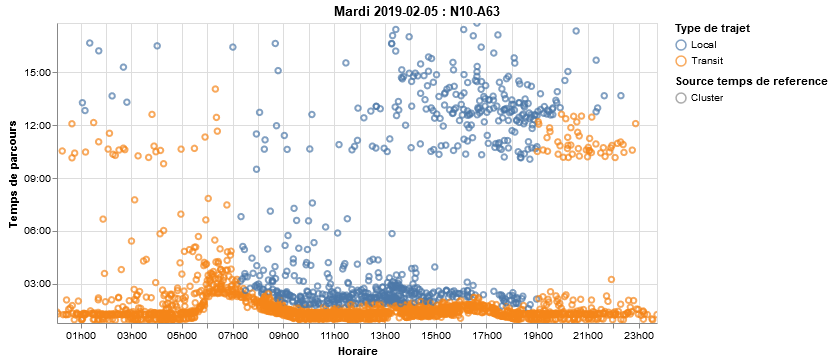

In [142]:
g.graph_transit_filtre(df_transit_marge0_ss_extrapolation,'2019-02-05 00:00:00', '2019-02-05 23:59:59','N10-A63')

## 3.3 Extrapolation pour recuperer les trajets manquants 

In [14]:
%%time
liste_od_ok=['A660-A62','A62-A63','A63-A62','A62-A10','A660-N10', 'A660-A10','N10-A63','A62-N10']
df_transit_extrapole=df_transit_marge0_ss_extrapolation.copy()
for od in [x for x in  df_transit_marge0_ss_extrapolation.o_d.unique().tolist() if x not in liste_od_ok ] : 
    for date in set([a[0].strftime('%Y-%m-%d') for a in t.creer_liste_date('2019-01-23',22)]):
            try : 
                 df_transit_extrapole=t.predire_type_trajet(df_transit_extrapole, od,date,600,35)
            except ValueError : 
                continue

Wall time: 6min 36s


***exemple d'impact de l'extrapolation***

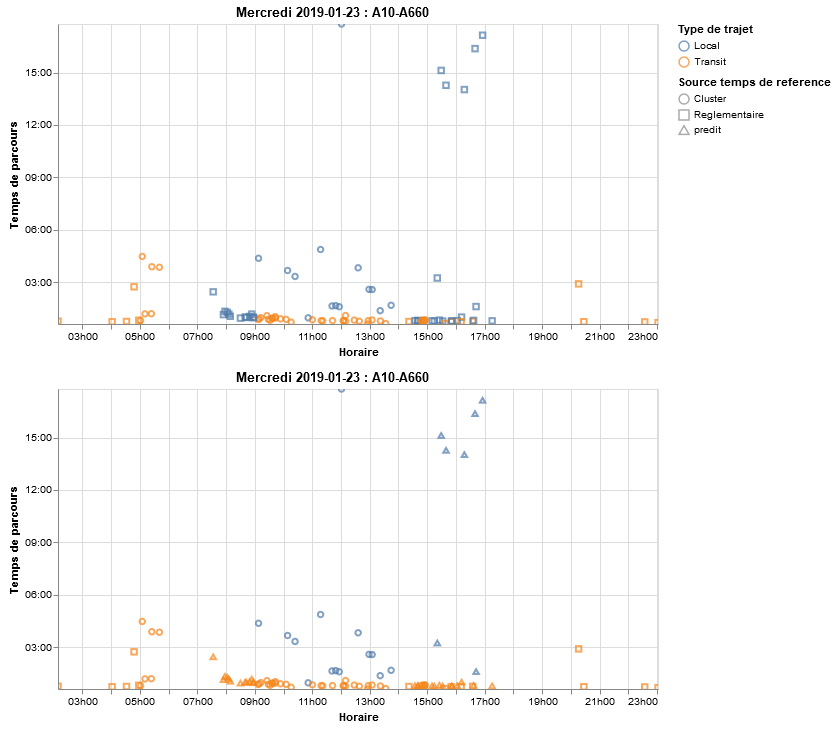

In [191]:
alt.vconcat(g.graph_transit_filtre_multiple(dico_df_transit['df_transit_marge0'],'2019-01-23 00:00:00', '2019-01-23 23:59:59','A10-A660', 1),
g.graph_transit_filtre_multiple(df_transit_extrapole,'2019-01-23 00:00:00', '2019-01-23 23:59:59','A10-A660', 1))            

***modification du dico des temps max avec ajout des temps de référence issu de l'extrapolation***

In [15]:
#localiser les periodes et o-d avec un temps de référence modifié
%time dixco_tpsmax_corrige=t.corriger_tps_parcours_extrapole(dixco_tpsmax_corrige,df_transit_extrapole)

Wall time: 1.2 s


## 3.4 Prendre en compte les aires entre Cestas et A63
> L'idée est que si le PL fait un trajet depuis ou vers A63 et qu'il est vu à Cestas, alors on va prendre en compte comm etemps de référence le temps entre Cestas et la l'entrée ou la sortuie du dispositif LAPI, pour s'abroger des temps de pause sur les grosses aires de A63

In [16]:
#creation des attributs relatifs a Cestas, pour les PL sur une O-D liées à A63, non identifiés comme transit, et qui ont été vus à Cestas
%time df_transit_A63_redresse=t.correction_temps_cestas(df_transit_extrapole,df_passages_immat_ok,dixco_tpsmax_corrige)

Wall time: 1min 50s


## 3.5 appliquer une marge 

In [17]:
%%time
#appliquer la martge sur les donnees issu de l'extrapolation et sur celle issues de la prise ene compte des aires
dico_df_transit={}
for i in [0,15,30,45,60,90] :
    dico_df_transit['df_transit_extrapole_marge'+str(i)]=t.identifier_transit(df_transit_extrapole, i)
    dico_df_transit['df_transit_airesA63_marge'+str(i)]=t.identifier_transit(df_transit_A63_redresse, i,'temps_filtre_cestas','tps_parcours_cestas')
#mettre en forme les données de prise en compte des aires
for i in [0,15,30,45,60,90] :
    dico_df_transit['df_transit_airesA63_marge'+str(i)]=t.forme_df_cestas(dico_df_transit['df_transit_airesA63_marge'+str(i)])
#concatener les 2 donnees
for i in [0,15,30,45,60,90] :
    dico_df_transit['df_transit_marge'+str(i)]=pd.concat([dico_df_transit['df_transit_airesA63_marge'+str(i)],
                                                         dico_df_transit['df_transit_extrapole_marge'+str(i)]],sort=False)
#remplir les valeurs NaN de correction_o_d
for i in [0,15,30,45,60,90] :
    dico_df_transit['df_transit_marge'+str(i)].correction_o_d=(dico_df_transit['df_transit_marge'+str(i)].
                                                               correction_o_d.fillna(False).copy())

Wall time: 2min 37s
Parser   : 109 ms


In [90]:
#exemple de visu sur 3 semaines
for od in dico_df_transit['df_transit_marge0'].o_d.unique(): 
    for i in [0,15,30,45,600] :
        nom_chemin=r'Q:\DAIT\TI\DREAL33\2018\C17SI0073_LAPI\Traitements\python\graphs\transit_J_OD\marge_'+str(i)+'_min'
        chemin=os.path.join(nom_chemin,f'{od}.svg')
        g.graph_transit_filtre_multiple(dico_df_transit['df_transit_marge'+str(i)],'2019-01-23 00:00:00', '2019-01-23 23:59:59',od, 22).save(chemin)

***Impact de la marge***

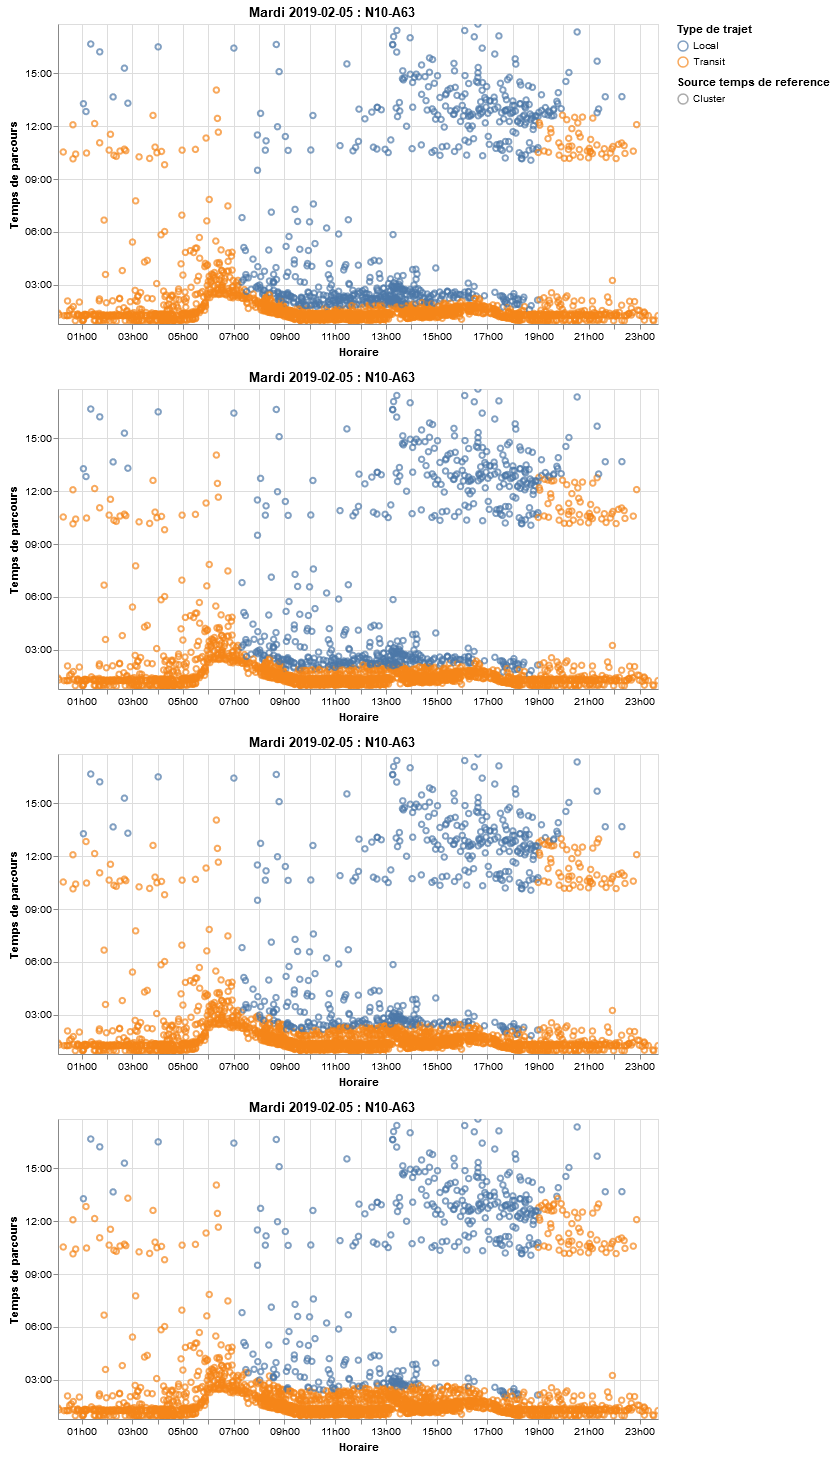

In [139]:
alt.vconcat(g.graph_transit_filtre(dico_df_transit['df_transit_marge0'],'2019-02-05 00:00:00', '2019-02-05 23:59:59','N10-A63'),
            g.graph_transit_filtre(dico_df_transit['df_transit_marge15'],'2019-02-05 00:00:00', '2019-02-05 23:59:59','N10-A63'),
            g.graph_transit_filtre(dico_df_transit['df_transit_marge30'],'2019-02-05 00:00:00', '2019-02-05 23:59:59','N10-A63'),
            g.graph_transit_filtre(dico_df_transit['df_transit_marge45'],'2019-02-05 00:00:00', '2019-02-05 23:59:59','N10-A63'))

***Filtre des données***

In [37]:
%%time
dico_df_od_ok={'df_od_ok_marge'+str(i):dico_df_transit['df_transit_marge'+str(i)].loc[dico_df_transit['df_transit_marge'+str(i)]['filtre_tps']==1]
         for i in [0,15,30,45,60,90]}
#dico_df_passag_ok={'df_passag_ok_marge'+str(i):t.trajet2passage(dico_df_od_ok['df_od_ok_marge'+str(i)],dico_passag) for i in [0,15,30,45,600]}

Wall time: 5.51 s


# 4. Correction des trajets depuis ou vers A660 relatifs à A63

In [21]:
%%time 
#recuperer les passages correspondant aux trajets identifies
dico_passag_avantcorr={'passag_avantcorr'+str(i):
                   t.trajet2passage(dico_df_od_ok ['df_od_ok_marge'+str(i)],df_passages_immat_ok) 
                   for i in [0,15,30,45,60,90]}

Wall time: 1h 53min 26s
Compiler : 156 ms


In [47]:
%%time 
dico_corr_A63_A660={'corr_A63_A660'+str(i):
                    t.correction_trajet(df_passages_immat_ok, dico_df_od_ok ['df_od_ok_marge'+str(i)])
                    for i  in [0,15,30,45,60,90]}

Wall time: 5h 42min
Compiler : 158 ms


# 5. Extrapolation des trajets non complets

In [49]:
dico_df_od_final={}

In [331]:
%%time
for i  in [60,90]:
    df_filtre_A63,df_passage_transit,df_non_transit=(t.param_trajet_incomplet('2019-01-23 00:00:00',
        dico_corr_A63_A660['corr_A63_A660'+str(i)],df_passages_immat_ok,
        dico_passag_avantcorr['passag_avantcorr'+str(i)]))
    trajet_transit_incomplet2, passage2=t.transit_trajet_incomplet(df_filtre_A63,df_passage_transit,'2019-01-23 00:00:00',22, df_passages_immat_ok)
    #affectation des temps de parcours de reference
    df_transit_incomplet_tps_ref=t.jointure_temps_reel_theorique(trajet_transit_incomplet2,dixco_tpsmax_corrige,t.liste_trajet_incomplet,'incomplet')
    #Maj de l'attruibut drapeau et Maj des autres attruibuts
    df_transit_incomplet_tps_ref=t.identifier_transit(df_transit_incomplet_tps_ref, 0)
    #mettre en forme les attributs
    df_transit_incomplet_tps_ref=df_transit_incomplet_tps_ref[['date_cam_1', 'immat', 'state', 'l', 'date_cam_2', 'cameras', 'origine',
           'destination', 'o_d', 'tps_parcours', 'period', 'date', 'temps', 'type',
           'tps_parcours_theoriq','temps_filtre', 'filtre_tps']]
    #filtrer le df : 
    df_transit_incomplet_tps_ref_final=df_transit_incomplet_tps_ref.loc[df_transit_incomplet_tps_ref['filtre_tps']==1].copy()
    #ajouter l'attribut d'identification des trajets 
    df_transit_incomplet_tps_ref_final['correction_o_d']=True
    df_transit_incomplet_tps_ref_final['correction_o_d_type']='extrapole'
    #6. Ajouter au df des o_d précédents : 
    dico_df_od_final['df_od_final_marge'+str(i)]=pd.concat([dico_corr_A63_A660['corr_A63_A660'+str(i)],df_transit_incomplet_tps_ref_final],sort=False)

date : 2019-01-23 00:00:00 debut_traitement : 2019-06-18 00:16:20.063249
date : 2019-01-24 00:00:00 debut_traitement : 2019-06-18 00:30:16.601270
date : 2019-01-25 00:00:00 debut_traitement : 2019-06-18 00:39:59.573809
date : 2019-01-26 00:00:00 debut_traitement : 2019-06-18 00:47:52.041066
date : 2019-01-27 00:00:00 debut_traitement : 2019-06-18 00:53:28.868229
date : 2019-01-28 00:00:00 debut_traitement : 2019-06-18 00:56:16.736125
date : 2019-01-29 00:00:00 debut_traitement : 2019-06-18 01:03:01.924782
date : 2019-01-30 00:00:00 debut_traitement : 2019-06-18 01:09:19.243753
date : 2019-01-31 00:00:00 debut_traitement : 2019-06-18 01:17:14.133941
date : 2019-02-01 00:00:00 debut_traitement : 2019-06-18 01:20:54.457936
date : 2019-02-02 00:00:00 debut_traitement : 2019-06-18 01:24:32.001280
date : 2019-02-03 00:00:00 debut_traitement : 2019-06-18 01:27:29.866278
date : 2019-02-04 00:00:00 debut_traitement : 2019-06-18 01:29:26.167448
date : 2019-02-05 00:00:00 debut_traitement : 2019-

In [332]:
#sauvegarder les resultats
for i in [0,15,30,45,60,90]:
    nomfichier=f'marge{i}min.json'
    dico_df_od_final['df_od_final_marge'+str(i)].reset_index().drop(['level_0','index'],axis=1).to_json(
        os.path.join(r'Q:\DAIT\TI\DREAL33\2018\C17SI0073_LAPI\Projet Rapport\resultats',nomfichier),orient='index')

# 6. Créer les tableaux de matrice o_d

## 6.1 Resultats

### 6.1.1 Nb total de veh sur la periode

In [114]:
# dico des o-d nombre total
dico_mat_od={'mat_od_marge'+str(i):pd.pivot_table(dico_df_od_ok['df_od_ok_marge'+str(i)],values='l', index='origine', 
                                                  columns='destination',aggfunc='count', margins=True).fillna('NC') for i in [0,15,30,45,600]}

In [130]:
mat_od_tot=pd.pivot_table(dico_df_od_final['df_od_final_marge45'],values='l', index='origine', 
                                                  columns='destination',aggfunc='count', margins=True).fillna('NC')
mat_od_tot_calcul=pd.pivot_table(dico_df_od_final['df_od_final_marge45'],values='l', index='origine', 
                                                  columns='destination',aggfunc='count').fillna('NC')
mat_od_tot

destination,A10,A62,A63,A660,A89,N10,All
origine,,,,,,,
A10,NC,5972,12453,1809,332,NC,20566
A62,6105,NC,798,1027,1058,7298,16286
A63,11996,495,NC,NC,2975,57743,73209
A660,1572,868,NC,NC,964,5147,8551
A89,299,966,4046,1292,NC,NC,6603
N10,NC,4767,47329,4629,NC,NC,56725
All,19972,13068,64626,8757,5329,70188,181940


### 6.1.2 mjo, mjo+samedi, mja

Pour faire du MJO il faut connaitre les dates à enlever de certaines O-D car il ya des trous dans les données, cf Q:\DAIT\TI\DREAL33\2018\C17SI0073_LAPI\donnees_verif_fiabilite\Synthese_absence_donnees.ods

depuis N10 : supprimer les 29/01 et 30/01<br>vers A10 supprimer le 01/02<br>vers A62 supprimer le 24/01<br>depuis A63 supprimer le 31/01<br>depuis A89 supprimer le 06/02<br>vers A89 supprimer le 06/02

In [456]:
# filtre des dates selon les jours indisponible pour supprimer tout la journee
df_transit_filtre=dico_df_od_final['df_od_final_marge45'].loc[dico_df_od_final['df_od_final_marge45'].apply(lambda x : 
not (x['cameras'][0]==6 and (x['date_cam_1'].day==pd.to_datetime('2019-01-29').day or x['date_cam_1'].day==pd.to_datetime('2019-01-30').day)) and 
not (x['cameras'][-1]==11 and x['date_cam_1'].day==pd.to_datetime('2019-02-01').day) and 
not (x['cameras'][-1]==9 and x['date_cam_1'].day==pd.to_datetime('2019-01-24').day) and
not (x['cameras'][0]==15 and x['date_cam_1'].day==pd.to_datetime('2019-01-31').day) and 
not (x['cameras'][-1]==7 and x['date_cam_1'].day==pd.to_datetime('2019-02-06').day) and 
not (x['cameras'][0]==8 and x['date_cam_1'].day==pd.to_datetime('2019-02-06').day),axis=1)]

In [458]:
#filtre des dates pour supprimer les WE
df_transit_jo=df_transit_filtre.loc[df_transit_filtre.set_index('date_cam_1').index.dayofweek<5]

In [128]:
#matrice_o_d jours ouvres
mat_o_d_jo_marge45=round(pd.pivot_table(df_transit_jo,values='l', index='origine', columns='destination',aggfunc='count')/t.matrice_nb_jo,0)
mat_o_d_jo_marge45

In [129]:
pd.pivot_table(df_transit_jo,values='l', index='origine', columns='destination',aggfunc='count')

destination,A10,A62,A63,A660,A89,N10
origine,,,,,,
A10,NaN,5277.0,10189.0,1528.0,301.0,NaN
A62,5545.0,NaN,765.0,995.0,976.0,6991.0
A63,9765.0,447.0,NaN,NaN,2577.0,46931.0
A660,1346.0,798.0,NaN,NaN,885.0,4588.0
A89,267.0,822.0,3491.0,1159.0,NaN,NaN
N10,NaN,3981.0,34530.0,3661.0,NaN,NaN


## 6.2 Illsutrations impacts des paramètres

### 6.2.1 Impact methode de prediction sur marge0

In [160]:
pd.pivot_table(dico_extrapole_prediction['marge15'].loc[dico_extrapole_prediction['marge15']['filtre_tps']==1],values='l', index='origine', 
                                                  columns='destination',aggfunc='count', margins=True).fillna('NC')

destination,A10,A62,A63,A660,A89,N10,All
origine,,,,,,,
A10,NC,5643,8459,2469,341,NC,16912
A62,5489,NC,362,1100,1015,6909,14875
A63,8002,266,NC,NC,2031,41587,51886
A660,2093,834,NC,NC,1129,8239,12295
A89,292,937,2924,1551,NC,NC,5704
N10,NC,4536,34111,7461,NC,NC,46108
All,15876,12216,45856,12581,4516,56735,147780


### 6.2.2 Impact redressement vaeurs A63 et A660

In [173]:
# donnees de base
pl_transit_base=df_transit_marge0_ss_extrapolation.loc[df_transit_marge0_ss_extrapolation['filtre_tps']==1].copy()

In [175]:
pd.pivot_table(pl_transit_base, values='l',index='origine', columns='destination',aggfunc='count', margins=True).fillna('NC')

destination,A10,A62,A63,A660,A89,N10,All
origine,,,,,,,
A10,NC,5265,7658,1954,182,NC,15059
A62,5183,NC,306,740,734,6664,13627
A63,7400,202,NC,NC,1654,39887,49143
A660,1869,577,NC,NC,784,7882,11112
A89,207,659,2340,1125,NC,NC,4331
N10,NC,4143,32739,7086,NC,NC,43968
All,14659,10846,43043,10905,3354,54433,137240


In [169]:
# donnees redressee
pd.pivot_table(df_od_corrige,values='l', index='origine', columns='destination',aggfunc='count', margins=True).fillna('NC')

destination,A10,A62,A63,A660,A89,N10,All
origine,,,,,,,
A10,NC,5265,7666,1946,182,NC,15059
A62,5183,NC,332,714,734,6664,13627
A63,7760,233,NC,NC,1767,40181,49941
A660,1509,546,NC,NC,671,7588,10314
A89,207,659,2402,1063,NC,NC,4331
N10,NC,4143,32839,6986,NC,NC,43968
All,14659,10846,43239,10709,3354,54433,137240


### 6.2.3 impact trajets non complet

In [272]:
pd.pivot_table(df_od_final,values='l', index='origine', columns='destination',aggfunc='count', margins=True).fillna('NC')

destination,A10,A62,A63,A660,A89,N10,All
origine,,,,,,,
A10,NC,5298,7666,1946,182,NC,15092
A62,5183,NC,332,714,741,6692,13662
A63,7760,235,NC,NC,1777,40482,50254
A660,1509,546,NC,NC,671,7588,10314
A89,207,665,2402,1063,NC,NC,4337
N10,NC,4158,32839,6986,NC,NC,43983
All,14659,10902,43239,10709,3371,54762,137642


### 6.2.4 impact prise en compte aires

In [136]:
dico_df_transit['df_transit_extrapole_marge0'].loc[dico_df_transit['df_transit_extrapole_marge0']['filtre_tps']==1].pivot_table(
    values='l', index='origine', columns='destination',aggfunc='count').fillna('NC')

destination,A10,A62,A63,A660,A89,N10
origine,,,,,,
A10,NC,5265,7658,1954,182,NC
A62,5183,NC,306,740,734,6664
A63,7400,202,NC,NC,1654,39887
A660,1869,577,NC,NC,784,7882
A89,207,659,2340,1125,NC,NC
N10,NC,4143,32739,7086,NC,NC


In [137]:
dico_df_transit['df_transit_airesA63_marge0'].loc[dico_df_transit['df_transit_extrapole_marge0']['filtre_tps']==1].pivot_table(
    values='l', index='origine', columns='destination',aggfunc='count').fillna('NC')

destination,A10,A62,A63,A89,N10
origine,,,,,
A10,NC,NC,2336,NC,NC
A62,NC,NC,440,NC,NC
A63,2411,138,NC,474,7384
A89,NC,NC,772,NC,NC
N10,NC,NC,6874,NC,NC


# 7. Différeciation Rocade Est-Ouest
>Cette analyse ne concerne que les trajets N10-A63, A10-A63, N10-A660, A10-A660

In [57]:
pivot_type_rocade

type_rocade,Autre,Est,Ouest,All
o_d,,,,
A10-A63,474,4126,153,4753
A10-A660,159,597,38,794
A63-A10,715,3053,38,3806
A660-A10,248,669,10,927
A660-N10,1184,2892,40,4116
N10-A63,2106,19016,644,21766
N10-A660,589,2205,101,2895
All,5475,32558,1024,39057


# 7. Analyse du nb de VL, PL, PL en transit par heure et par camera 
> Le pb c'est que pour les camera de la Rocade, parfois on les PL n'y sont pas vus, de même pour les chemins extrapoles ou pour ceux corrigés : le passage soit n'existe pas, soit la camera du passage ne correspond pas à la destination finalement utilisées

## 7.1 base : travail sur les données telles que créees

In [373]:
#passages de transit
passages_transit=t.trajet2passage(dico_df_od_final['df_od_final_marge45'],df_passages_immat_ok)

In [459]:
#filtrer les passages de transit selon les jours avec pb
passages_transit_filtre=passages_transit.loc[passages_transit.apply(lambda x : 
not (x['camera_id']==6 and (x['created'].day==pd.to_datetime('2019-01-29').day or x['created'].day==pd.to_datetime('2019-01-30').day)) and 
not (x['camera_id']==11 and x['created'].day==pd.to_datetime('2019-02-01').day) and 
not (x['camera_id']==9 and x['created'].day==pd.to_datetime('2019-01-24').day) and
not (x['camera_id']==15 and x['created'].day==pd.to_datetime('2019-01-31').day) and 
not (x['camera_id']==7 and x['created'].day==pd.to_datetime('2019-02-06').day) and 
not (x['camera_id']==8 and x['created'].day==pd.to_datetime('2019-02-06').day),axis=1)]

In [460]:
%time synth_pl=t.pourcentage_pl_camera(df_passages_immat_ok,passages_transit_filtre)

Wall time: 2.69 s


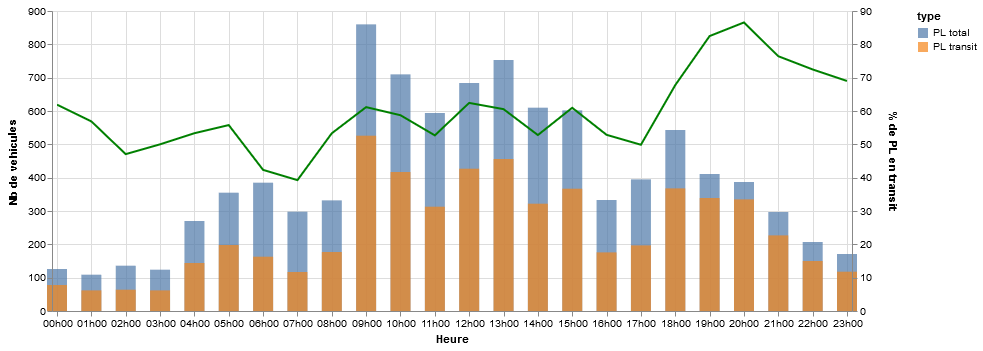

In [484]:
#penser à filtrer les données selon les mêmes jours que pour les pivot table
g.graph_VL_PL_transit_j_cam(synth_pl, '2019-02-05', 4)

## 7.2 Redressement au niveau de la Rocade

In [462]:
#determiner les passages fictifs
df_passage_transit_redresse, df_pl_redresse, trajets_rocade_non_vu=t.passages_fictif_rocade (
    t.liste_trajet_rocade, df_transit_filtre,passages_transit_filtre,df_passages_immat_ok)

In [463]:
#regrouper
%time synt_nb_veh_cam_redresse=t.pourcentage_pl_camera(df_pl_redresse,df_passage_transit_redresse)

Wall time: 4.64 s


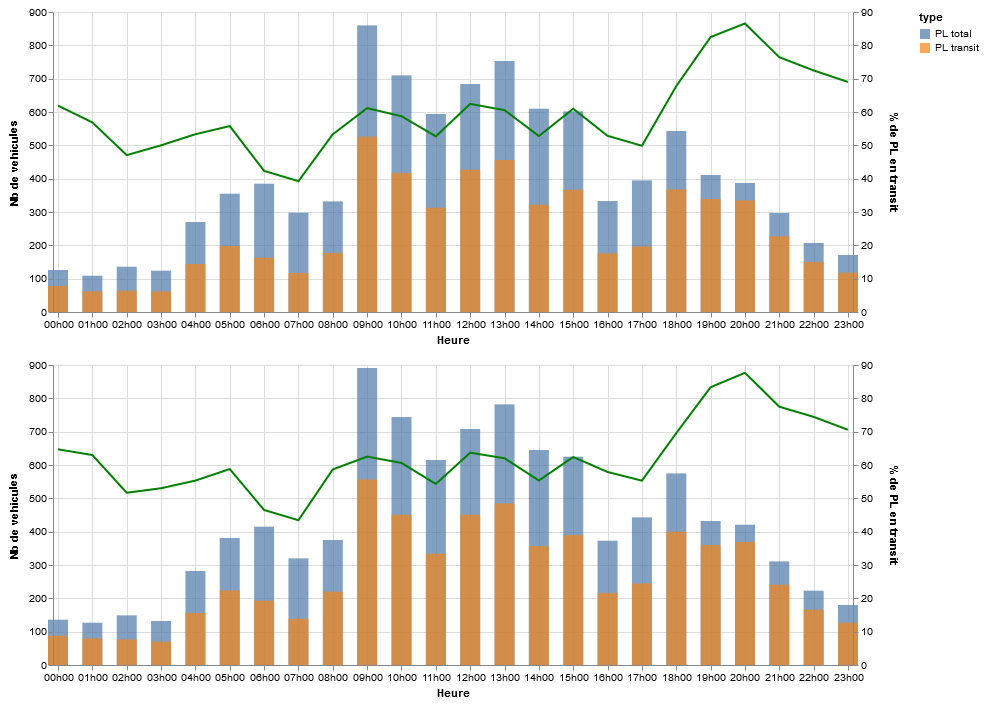

In [497]:
alt.vconcat(g.graph_VL_PL_transit_j_cam(synth_pl, '2019-02-05', 4),g.graph_VL_PL_transit_j_cam(synt_nb_veh_cam_redresse, '2019-02-05',4))

## 7.4. Grouper les réusltats par JO

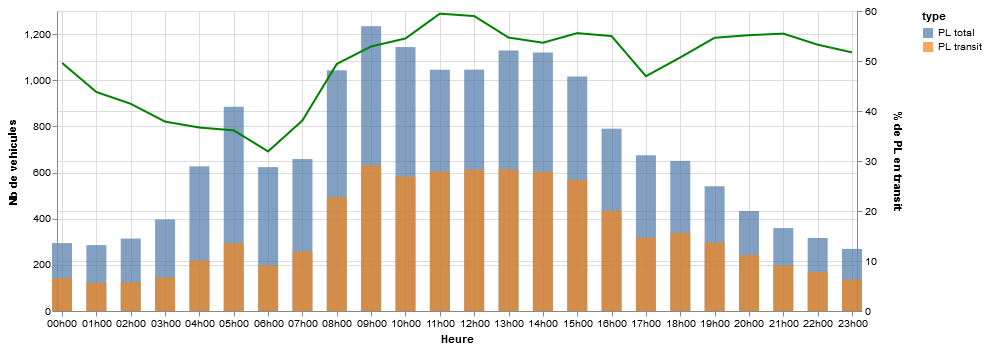

In [500]:
g.graph_VL_PL_transit_j_cam(synt_nb_veh_cam_redresse, 'JO', 3,4)

## 7.5 Chiffre global de transit

In [505]:
#pourcentage global sur toute les cameras
len(passages_transit)/len(df_passages_immat_ok)*100

54.01922762866395

In [506]:
#ciblé rocade Est avec prise en compte redressement
(len(df_passage_transit_redresse.loc[df_passage_transit_redresse['camera_id'].isin([3,4])]) / 
len(df_pl_redresse.loc[df_pl_redresse['camera_id'].isin([3,4])]))*100

51.98736824412775

# 8. Temps de parcours

In [26]:
# on cherche à obtenir le temps de parcours moyen pour une camera, sur un jour ou les jours ouvres, par o_d
# on construit donc une df avec : immat, cam, tps_parcours, heure_Rocade
# pour l'heure à la Rocade : on va cehrcher dans les df_passage le passage:qui a la mm immat, dont la cam est 1,2,3,4 et dont le created est compris entre date_cam1et date_cam2

#isoler les passages concernes par la Rocade
passage_rocade=dico_passag_final.loc[(dico_passag_final['camera_id'].isin([1,2,3,4]))]# & (dico_passag_final['correction_o_d']==False)]

In [36]:
#jointure entre les o_d et les passages
o_d_joint_rocade=dico_od_final.merge(passage_rocade, on='immat', how='left')

In [109]:
#limiter les o_d là ou date du passages est ciompris entre les date 1 et date 2 de l'o_d
dico_od_Rocade_final=o_d_joint_rocade.loc[(o_d_joint_rocade['date_cam_1']<o_d_joint_rocade['created']) & 
                                          (o_d_joint_rocade['created']<o_d_joint_rocade['date_cam_2']) & 
                                          (o_d_joint_rocade['tps_parcours']<pd.Timedelta('4H'))]

In [155]:
#limiter les 
limite_donnees=dico_od_Rocade_final[['date_cam_1','immat','o_d','tps_parcours','created']].rename(columns={'created':'h_rocade'})

In [181]:
#filtrer selon une date ou des jours ouvrés ou mardi/jeudi : 
"""filtre_donnees=limite_donnees.loc[(limite_donnees.apply(lambda x : x['h_rocade'].dayofyear==pd.to_datetime('2019-01-28').dayofyear,axis=1)) & 
                          (pour_graph['o_d']=='A10-A62')].copy()"""
filtre_donnees=limite_donnees.loc[(limite_donnees.set_index('h_rocade').index.dayofweek<5) & 
                          (limite_donnees['o_d']=='A10-A63')].copy()
"""filtre_donnees=limite_donnees.loc[(limite_donnees.set_index('h_rocade').index.dayofweek.isin([1,3])) & 
                          (limite_donnees['o_d']=='A10-A62')].copy()"""

"filtre_donnees=limite_donnees.loc[(limite_donnees.set_index('h_rocade').index.dayofweek.isin([1,3])) & \n                          (limite_donnees['o_d']=='A10-A62')].copy()"

In [182]:
#transformer les valeur de temps en integer pour agregation
filtre_donnees['tps_parcours2']=filtre_donnees['tps_parcours'].values.astype(np.int64)

In [ ]:
#mise en forme pour graph
groupe_h=filtre_donnees.set_index('h_rocade').resample('15T')['tps_parcours2'].mean()
#groupe_h['tps_parcours']=pd.to_timedelta(groupe_h['tps_parcours'])
groupe_h=pd.to_timedelta(groupe_h)
pour_graph=groupe_h.reset_index()
pour_graph['tps_parcours2']=pd.to_datetime('2019-01-31')+pour_graph['tps_parcours2']

In [ ]:
pour_graph

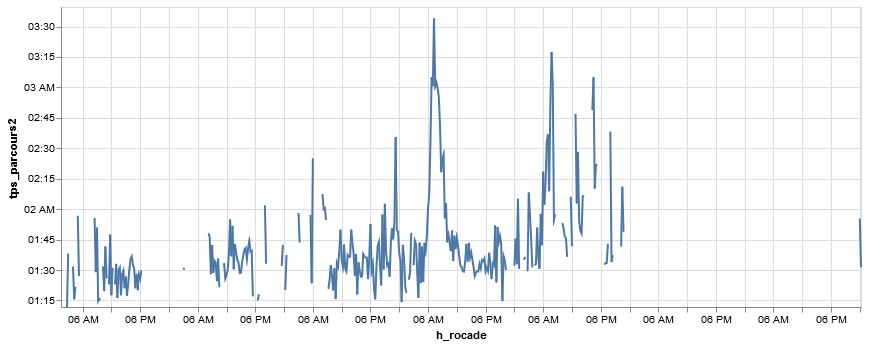

In [184]:
alt.Chart(pour_graph).mark_line().encode(
    x='h_rocade:T',
    y='tps_parcours2').properties(width=800)

In [ ]:
dico_od_final.loc[(dico_od_final['o_d']=='A10-A62') & (dico_od_final['date_cam_1']>pd.to_datetime('2019-01-28 21:00'))].sort_values('date_cam_1')

In [559]:
test=t.trajet(df_passages6.loc['2019-01-31 00:00:00':'2019-02-01 23:59:59'], '2019-01-31 08:15:00', 15, [8, 13],typeTrajet='Global',temps_max_autorise=18)

In [547]:
param_cluster=pd.read_json(r'Q:\DAIT\TI\DREAL33\2018\C17SI0073_LAPI\Traitements\python\param_cluster.json', orient='index')

In [563]:
visu=t.jointure_temps_reel_theorique(test.df_transit,dixco_tpsmax_corrige,t.liste_complete_trajet, 15)

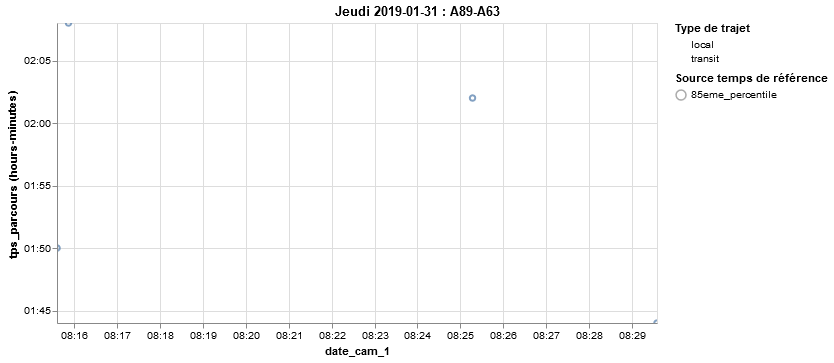

In [564]:
g.graph_transit_filtre(visu,'2019-01-31 00:00:00','2019-01-31 23:59:59','A89-A63')

# CORRIGER LES TEMPS DE PARCOURS LIMITES

In [162]:
#isoler les données : sur un jour pour une o_d
o_d='A10-A63'
date='2019-01-23'
test_predict=dico_df_transit['df_transit_marge0'].loc[(dico_df_transit['df_transit_marge0']['o_d']==o_d) &
             (dico_df_transit['df_transit_marge0'].set_index('date_cam_1').index.dayofyear==pd.to_datetime(date).dayofyear)].copy()

In [163]:
#ajouter des champsde ocnversion des dates en integer, limiter les valeusr sinon pb de mémoire avec sklearn
test_predict['date_int']=((test_predict.date_cam_1 - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s'))/1000000
test_predict['temps_int']=(((pd.to_datetime('2018-01-01')+test_predict.tps_parcours) - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s'))/1000000

In [1074]:
#créer les données d'entrée du modele
X=np.array([[a,b] for a,b in zip(test_predict.date_int.tolist(),test_predict.temps_int.tolist())])
y=np.array(test_predict.filtre_tps.tolist())

In [1075]:
#créer le modele
ga=1000
C=35
clf = svm.SVC(kernel='rbf', gamma=ga, C=C)

In [1076]:
#alimenter le modele
clf.fit(liste_nsample_nfeat, n_sample)

SVC(C=35, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1000, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [1077]:
#isoler les donner à tester
df_a_tester=test_predict.loc[(test_predict['filtre_tps']==0) & (test_predict['type']=='85eme_percentile')].copy()

In [1078]:
#liste à tester
liste_a_tester=np.array([[a,b] for a,b in zip(df_a_tester.date_int.tolist(),df_a_tester.temps_int.tolist())])
#dfde résultats de prédiction
df_type_predit=pd.DataFrame([[i, v] for i,v in zip(df_a_tester.index.tolist(),[clf.predict([x])[0] for x in liste_a_tester])], 
                            columns=['index_source','type_predit'])
#mise à jourde la df source
df_transit_avec_filtre.loc[df_transit_avec_filtre.index.isin(df_type_predit.index_source.tolist()),'type']='predit'
df_transit_avec_filtre.loc[df_transit_avec_filtre.index.isin(df_type_predit.loc[df_type_predit['type_predit']==1].index_source.tolist()),'filtre_tps']=1

In [1172]:
df_transit_avec_filtre.loc[df_transit_avec_filtre['type']=='predit']

,date_cam_1,immat,l,state,id,date_cam_2,cameras,origine,destination,o_d,tps_parcours,period,date,temps,type,tps_parcours_theoriq,filtre_tps


Wall time: 1.69 s


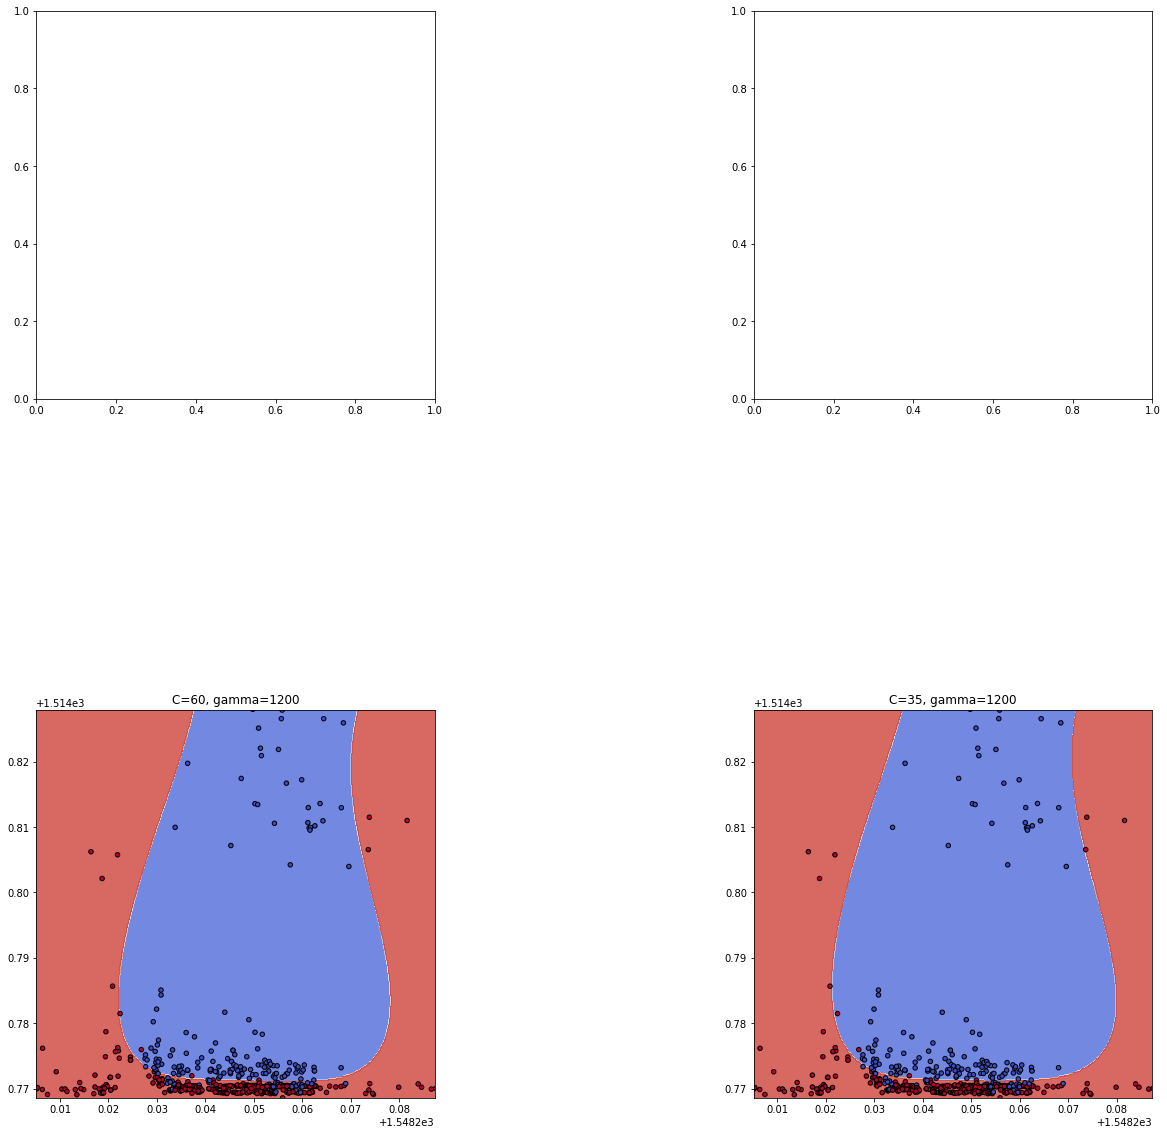

In [166]:
%%time
def make_meshgrid(x, y, h=.0002):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 0.000000001, x.max() + 0.000000001
    y_min, y_max = y.min() - 0.000000001, y.max() + 0.000000001
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

X=np.array([[a,b] for a,b in zip(test_predict.date_int.tolist(),test_predict.temps_int.tolist())])
y=np.array(test_predict.filtre_tps.tolist())
#C = 25# SVM regularization parameter
models = (svm.SVC(kernel='rbf', gamma=600, C=70),
         svm.SVC(kernel='rbf', gamma=600, C=35),
         svm.SVC(kernel='rbf', gamma=500, C=100),
         svm.SVC(kernel='rbf', gamma=500, C=200))
models = (clf.fit(X, y) for clf in models)


# Set-up 2x2 grid for plotting.
fig, sub = plt.figure(figsize=(20,20)).subplots(2,2)
plt.subplots_adjust(wspace=0.8, hspace=0.8)

# title for the plots
titles = ('C=60, gamma=1200',
          'C=35, gamma=1200',
          'C=100, gamma=500',
          'C=200, gamma=500')

X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_title(title)

#plt.show()
plt.savefig(r'Q:\DAIT\TI\DREAL33\2018\C17SI0073_LAPI\Projet Rapport\illustrations\impact_prediction_A10-A63.png')

In [ ]:
liste_od_ok=['A660-A62','A62-A63','A63-A62','A62-A10','A660-N10', 'A660-A10','N10-A63','A62-N10']
for od in [x for x in df_transit_avec_filtre.o_d.unique().tolist() if x not in liste_od_ok ] : 
    for date in set([a[0].strftime('%Y-%m-%d') for a in t.creer_liste_date('2019-01-31',11)]):
        try : 
            df_transit_avec_filtre=t.predire_type_trajet(df_transit_avec_filtre,od, date,600,35)
        except ValueError : 
            continue

# VERIF AFFECTATION CLUSTER

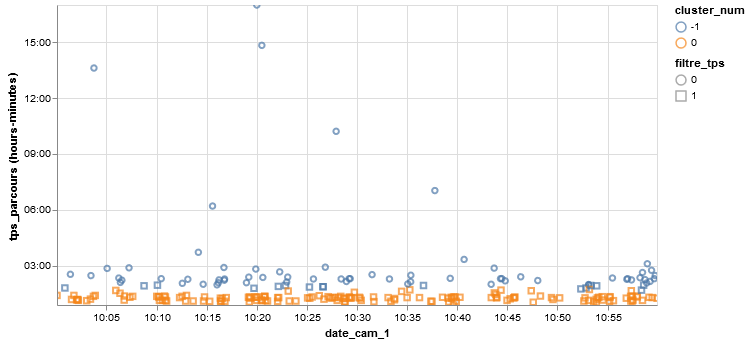

In [88]:
#test cluster
od='N10-A63'
date_debut='2019-01-23 10:00:00'
datefin='2019-01-23 11:00:00'
delai=1200
coeff=4
df_pl_ok=dico_df_transit['df_transit_marge15'].loc[(dico_df_transit['df_transit_marge15']['o_d']==od) &
                                   (dico_df_transit['df_transit_marge15']['date_cam_1'].between(pd.to_datetime(date_debut),pd.to_datetime(datefin)))]
donnees_src=df_pl_ok.loc[:,['date_cam_1','tps_parcours']].copy() #isoler les données necessaires
liste_valeur=donnees_src.tps_parcours.apply(lambda x : ((pd.to_datetime('2018-01-01')+x)-pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')).tolist()#convertir les temps en integer
liste_date=donnees_src.date_cam_1.apply(lambda x :(x - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')).tolist()
liste=[[liste_date[i],liste_valeur[i]] for i in range(len(liste_valeur))]
if len(liste_valeur)<5 : #si il n'y a pas bcp de pl on arrete ; pourraitfair l'objet d'un parametre
    raise ClusterError()
#faire tourner la clusterisation et recupérer le label (i.e l'identifiant cluster) et le nombre de cluster
clustering=DBSCAN(eps=delai, min_samples=len(liste_valeur)/coeff).fit(liste)

labels = clustering.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
# A AMELIORER EN CREANT UNE ERREUR PERSONALISEE SI ON OBTIENT  CLUSTER
if n_clusters_== 0 :
    print('vlaueError')
#mettre en forme au format pandas
results = pd.DataFrame(pd.DataFrame([donnees_src.index,labels]).T)
results.columns = ['index_base', 'cluster_num']
results = pd.merge(results,df_pl_ok, left_on='index_base', right_index=True )
graph_results=results[['date_cam_1','tps_parcours','filtre_tps','cluster_num']].copy()
graph_results.tps_parcours=pd.to_datetime('2018-01-01')+graph_results.tps_parcours
alt.Chart(graph_results).mark_point().encode(
                                x='date_cam_1',
                                y='hoursminutes(tps_parcours)',
                                tooltip='hoursminutes(tps_parcours)',
                                color='cluster_num:N',
                                shape='filtre_tps:N').interactive().properties(width=600)

# TESTS

In [410]:
pour_graph=toto.loc[(toto.apply(lambda x : x['created'].dayofyear==pd.to_datetime('2019-02-05').dayofyear,axis=1))&
                 (toto['camera_id']==3)]

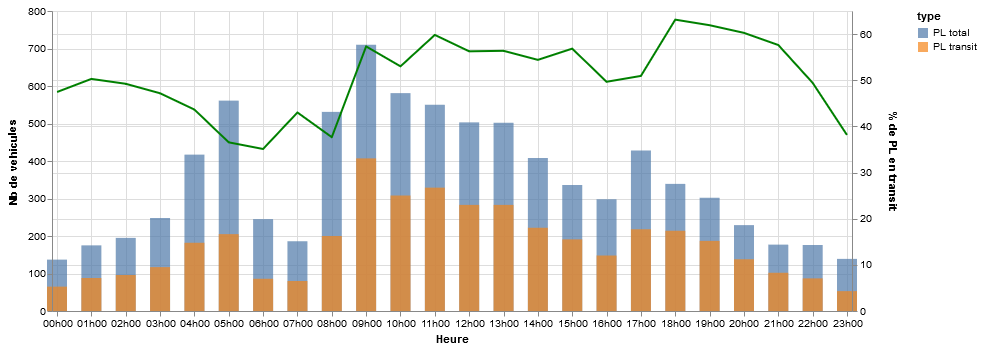

In [411]:
#graphique
base=alt.Chart(pour_graph).encode(x=alt.X('created', axis=alt.Axis(title='Heure', format='%Hh%M')))
bar = base.mark_bar(opacity=0.7, size=20).encode(
    y=alt.Y('nb_veh:Q',stack=None, axis=alt.Axis(title='Nb de vehicules')),
    color='type')
line=base.mark_line(color='green').encode(y=alt.Y('pct_pl_transit:Q', axis=alt.Axis(title='% de PL en transit')))
(bar+line).resolve_scale(y='independent').properties(width=800) 

In [406]:
toto=df_pl_concat.merge(df_pct_pl[['created','camera_id','pct_pl_transit']], on=['created','camera_id'])

In [480]:
synt_nb_veh_cam_redresse['heure']=synt_nb_veh_cam_redresse.created.dt.hour
groupe_jo=synt_nb_veh_cam_redresse.loc[synt_nb_veh_cam_redresse.set_index('created').index.dayofweek < 5].groupby(['camera_id','heure','type']).mean().reset_index()
groupe_jo['created']=groupe_jo.apply(lambda x : pd.to_datetime(0)+pd.Timedelta(str(x['heure'])+'H'),axis=1)
filtre=groupe_jo.loc[groupe_jo['camera_id'].isin([3,4])].sort_values(['heure','camera_id'])
filtre.groupby(['heure','type']).agg({'nb_veh':'sum','pct_pl_transit':'mean','created':'min'}).reset_index()

,heure,type,nb_veh,pct_pl_transit,created
0,0,PL total,294.1875,49.627697,1970-01-01 00:00:00
1,0,PL transit,142.5625,49.627697,1970-01-01 00:00:00
2,1,PL total,285.6250,43.800967,1970-01-01 01:00:00
3,1,PL transit,123.1875,43.800967,1970-01-01 01:00:00
4,2,PL total,313.8750,41.440480,1970-01-01 02:00:00
5,2,PL transit,125.0000,41.440480,1970-01-01 02:00:00
6,3,PL total,397.2500,37.879753,1970-01-01 03:00:00
7,3,PL transit,146.1875,37.879753,1970-01-01 03:00:00
8,4,PL total,626.8125,36.691287,1970-01-01 04:00:00
9,4,PL transit,219.3750,36.691287,1970-01-01 04:00:00


In [450]:
synt_nb_veh_cam_redresse

In [475]:
filtre.head(5)

,camera_id,heure,type,nb_veh,pct_pl_transit,created
96,3,0,PL total,162.8125,38.103191,1970-01-01 00:00:00
97,3,0,PL transit,62.0000,38.103191,1970-01-01 00:00:00
144,4,0,PL total,131.3750,61.152203,1970-01-01 00:00:00
145,4,0,PL transit,80.5625,61.152203,1970-01-01 00:00:00
98,3,1,PL total,161.5000,33.534956,1970-01-01 01:00:00
